In [448]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *

In [449]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# 1 - Load data sets 

In [450]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')

nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)
cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)
#cps['treat'] == 0 # created treated column
#load non experimental data (psid)
psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)
# reset indexes
nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)


# Exploratory Analysis

### Plotting functions

In [451]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [452]:
import matplotlib.gridspec as gridspec

class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [453]:
nsw[nsw['treat']==1].describe()
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [454]:
nswre74[nswre74['treat']==1].describe()
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


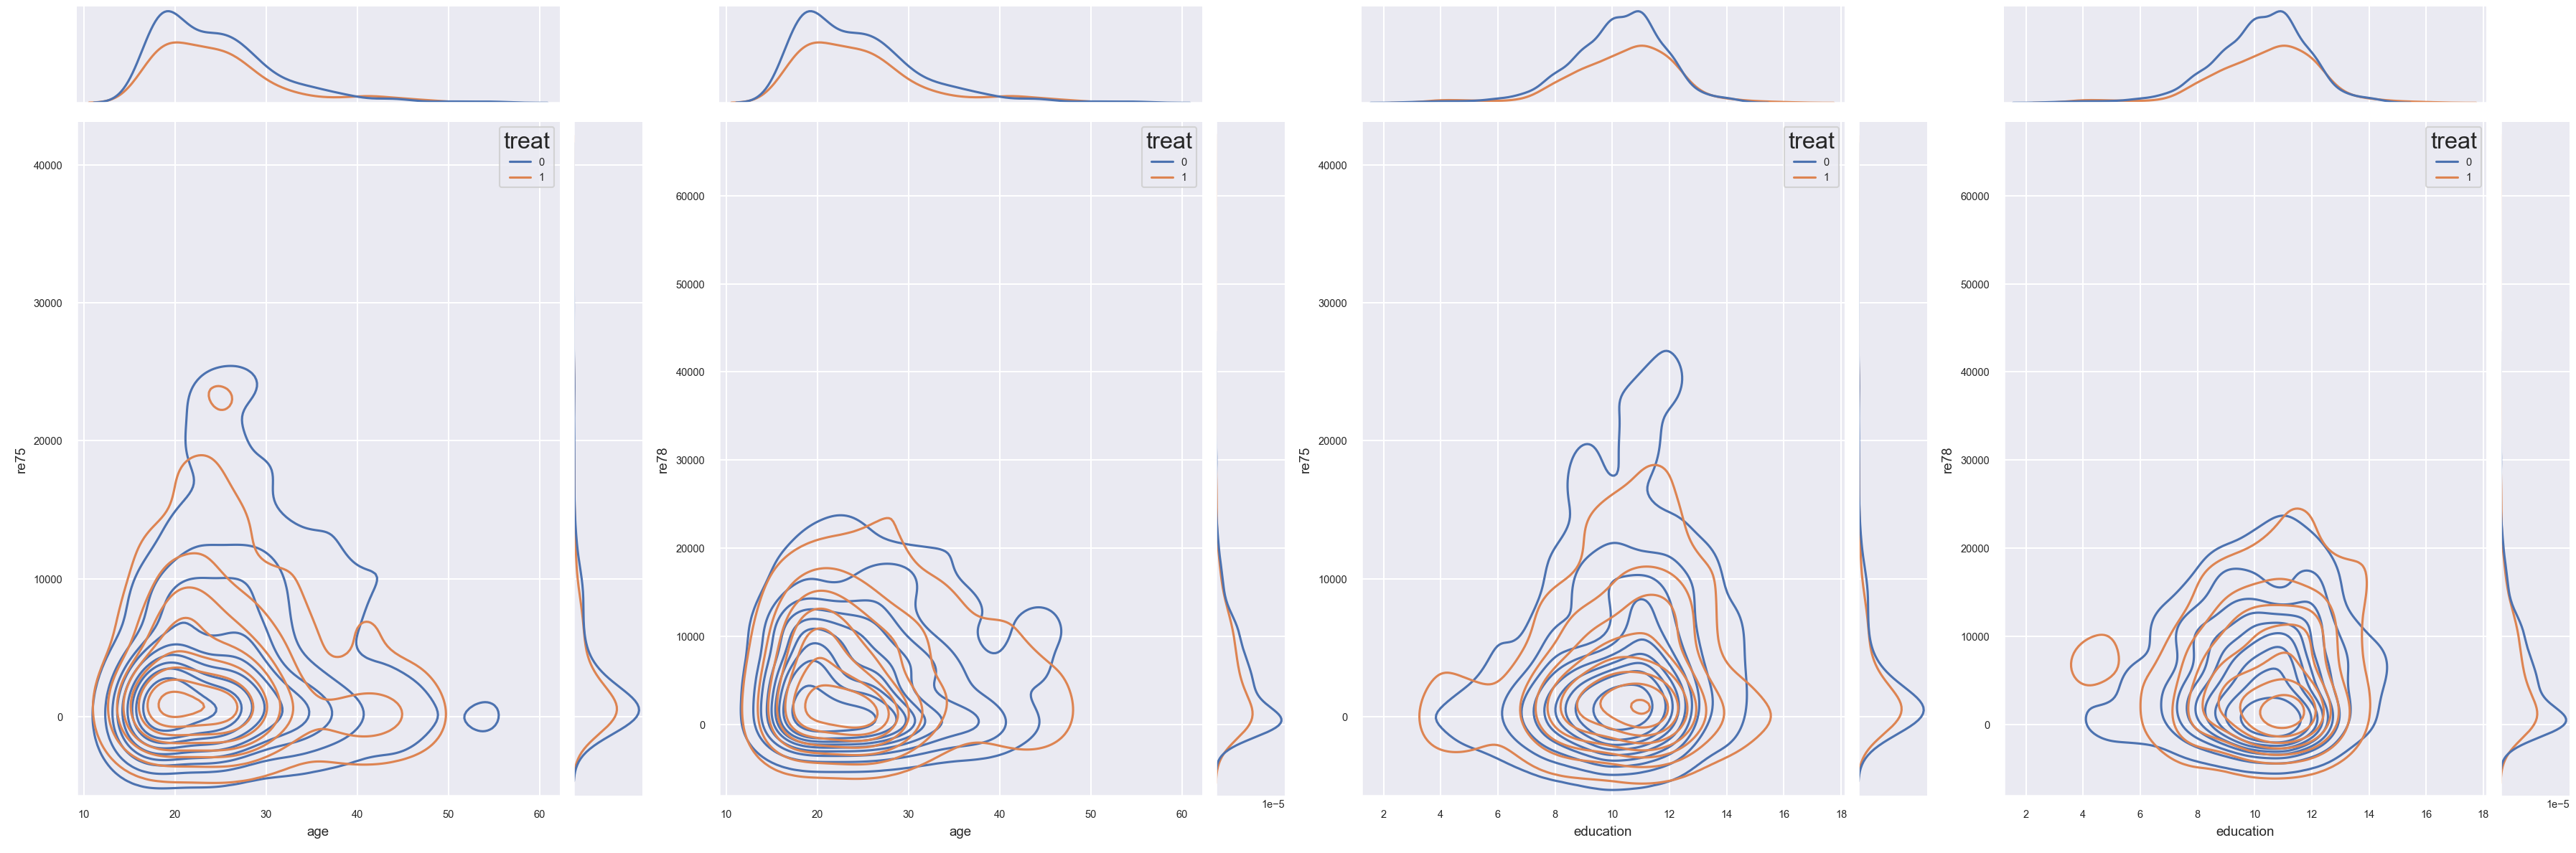

In [455]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


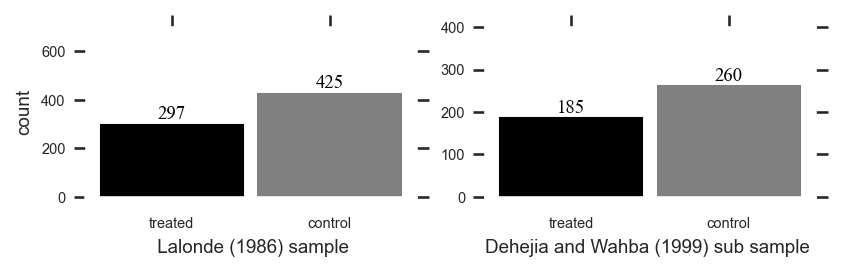

In [456]:
# Plot the balance of classes in the datasets 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

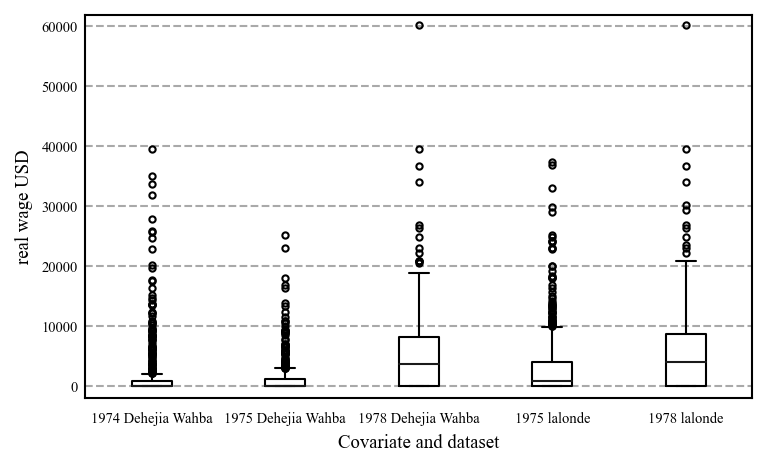

In [457]:
from tueplots import bundles 
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['1974 Dehejia Wahba', '1975 Dehejia Wahba','1978 Dehejia Wahba','1975 lalonde','1978 lalonde'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix1_wage_boxplots.png', bbox_inches='tight')
plt.show()

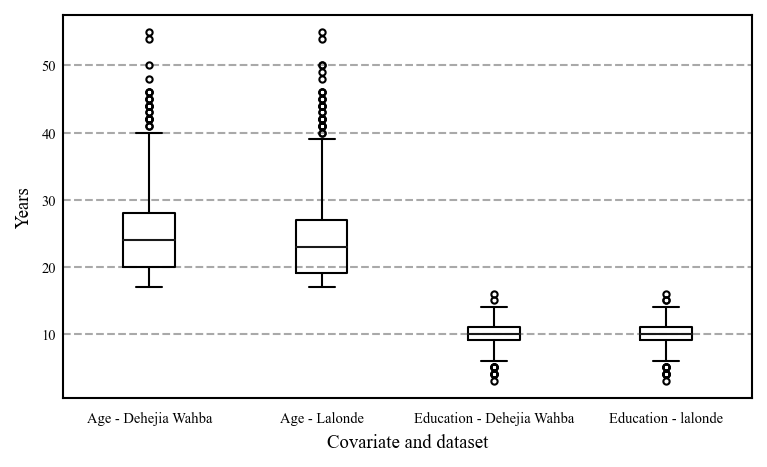

In [458]:
fig, ax = plt.subplots(figsize=(5, 3))
# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

Age_dej = nswre74['age']
Educ_dej = nswre74['education']



ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - Dehejia Wahba', 'Age - Lalonde','Education - Dehejia Wahba','Education - lalonde'])


ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('Years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

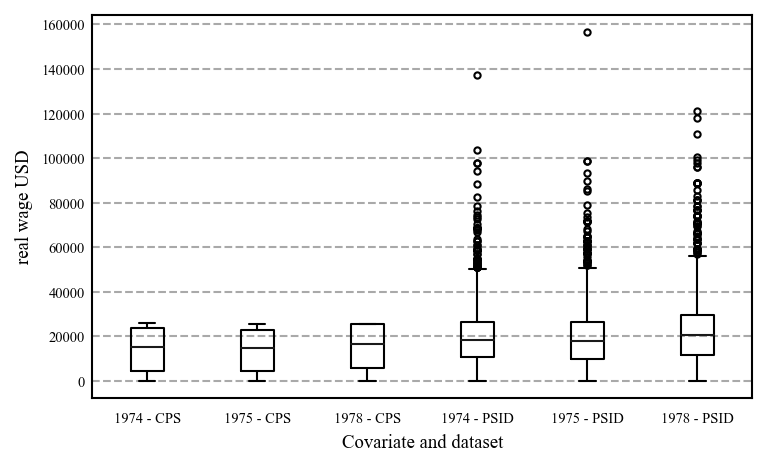

In [459]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps['re74']
wage75_cps = cps['re75']
wage78_cps = cps['re78']

wage74_psid = psid['re74']
wage75_psid = psid['re75']
wage78_psid = psid['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['1974 - CPS', '1975 - CPS','1978 - CPS','1974 - PSID','1975 - PSID','1978 - PSID'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix3_wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

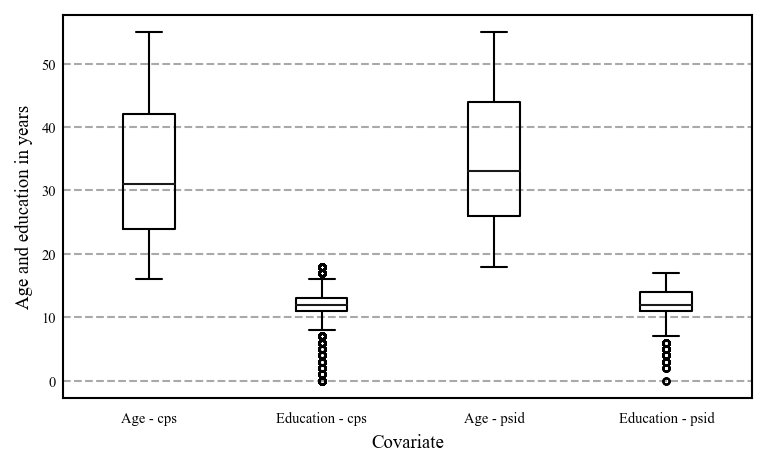

In [460]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps['age']
Educ_cps = cps['education']

Age_psid = psid['age']
Educ_psid = psid['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - cps', 'Education - cps','Age - psid','Education - psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix4_age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [461]:
# Drop outliers 
cols = ['re75','re78','age','education'] 
cols2 = ['re74','re75','re78','age','education'] 

lower_bound = 0.5
upper_bound = 0.95

Q1_1 = nsw[cols].quantile(lower_bound)
Q3_1 = nsw[cols].quantile(upper_bound)
IQR_1 = Q3_1 - Q1_1

Q1_2 = nswre74[cols2].quantile(lower_bound)
Q3_2 = nswre74[cols2].quantile(upper_bound)
IQR_2 = Q3_2 - Q1_2

Q1_3 = cps[cols2].quantile(lower_bound)
Q3_3 = cps[cols2].quantile(upper_bound)
IQR_3 = Q3_3 - Q1_3

Q1_4 = psid[cols2].quantile(lower_bound)
Q3_4 = psid[cols2].quantile(upper_bound)
IQR_4 = Q3_4 - Q1_4

nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

cps = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
psid = psid[~((psid[cols2] < (Q1_4 - IQR_4)) |(psid[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (o mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

In [462]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer

    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 

    warnings.filterwarnings('ignore')

    if 're74' in dataset.columns: 
        dataset['re74'] = dataset['re74'].astype(int)  
        warnings.filterwarnings('ignore')
    else:
        pass

    # Keep a copy of education as numerical 
    dataset['education*'] = dataset['education']

    # Generate dummy variables 
    dataset['u75'] = (dataset['re75'] == 0).astype(int)
    # Generate interaction terms 
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    
    if 're74' in dataset.columns: 
        dataset['u74'] = (dataset['re74'] == 0).astype(int)
        dataset['educ_re74'] = dataset['education']*dataset['re74']
        dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
        dataset['black_u74'] = dataset['black']*dataset['u74']
    else:
        pass    

    # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 0] = 1
    dataset['re75'][dataset['re75'] == 0] = 1

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 0] = 1
    else:
        pass     
        
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    dataset['re78sq'] = dataset['re78']*dataset['re78']
    dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['educsq'] = dataset['education']*dataset['education']

    if 're74' in dataset.columns:
        dataset['re74sq'] = dataset['re74']*dataset['re74']
    else:
        pass      

    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    else:
        pass     
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['lnre74'] = np.log(dataset['re74'])
    else:
        pass 

        # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 1] = 0
    dataset['re75'][dataset['re75'] == 1] = 0

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 1] = 0
    else:
        pass    

    # encode education as binary indicator variable 
    dataset = pd.get_dummies(dataset, columns=["education"],drop_first=True)
    
    return dataset  

In [463]:
# Combine lalonde treated units with cps and psid groups
cps_no_re74 = cps.drop(['re74'],axis=1)   # drop wage in 1974 from cps comparison
psid_no_re74 = psid.drop(['re74'],axis=1) # drop wage in 1974 from psid comparison

# Create quasi-experimental datasets 
Quasi_NswCps_lalonde_ = pd.concat([nsw[nsw['treat']==1],cps_no_re74],ignore_index=True)
Quasi_NswPsid_lalonde_ = pd.concat([nsw[nsw['treat']==1],psid_no_re74],ignore_index=True)
Quasi_NswCps_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],cps],ignore_index=True)
Quasi_NswPsid_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],psid], ignore_index=True)

# Pass data sets through feature transformation function 
Quasi_NswCps_lalonde = feature_tranform(Quasi_NswCps_lalonde_)
Quasi_NswPsid_lalonde = feature_tranform(Quasi_NswPsid_lalonde_)
Quasi_NswCps_dehWab = feature_tranform(Quasi_NswCps_dehWab_)
Quasi_NswPsid_dehWab = feature_tranform(Quasi_NswPsid_dehWab_)

In [464]:
Quasi_NswCps_lalonde

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10148,0.0,27,0.0,0.0,1.0,0.0,25243,25564,13,0,...,0,0,0,0,1,0,0,0,0,0
10149,0.0,55,0.0,0.0,1.0,1.0,25243,21463,9,0,...,1,0,0,0,0,0,0,0,0,0
10150,0.0,48,0.0,0.0,1.0,1.0,25243,25564,10,0,...,0,1,0,0,0,0,0,0,0,0
10151,0.0,47,0.0,0.0,1.0,1.0,11384,13671,9,0,...,1,0,0,0,0,0,0,0,0,0


In [465]:
Quasi_NswPsid_lalonde

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,0,0,0,1,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,0,1,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,0,0,0,1,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,0,0,0,1,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,0.0,32,0.0,0.0,1.0,1.0,39387,36943,10,0,...,0,0,1,0,0,0,0,0,0,0
2592,0.0,47,0.0,0.0,1.0,1.0,33837,38568,8,0,...,1,0,0,0,0,0,0,0,0,0
2593,0.0,32,0.0,0.0,1.0,1.0,67137,59109,8,0,...,1,0,0,0,0,0,0,0,0,0
2594,0.0,47,0.0,0.0,1.0,1.0,47968,55710,10,0,...,0,0,1,0,0,0,0,0,0,0


In [466]:
Quasi_NswCps_dehWab

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,0,9930,11,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,0,3595,9,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,0,24909,12,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,0,7506,11,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,0,289,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10038,0.0,27,0.0,0.0,1.0,0.0,25507,25243,25564,13,...,0,0,0,0,1,0,0,0,0,0
10039,0.0,55,0.0,0.0,1.0,1.0,25862,25243,21463,9,...,1,0,0,0,0,0,0,0,0,0
10040,0.0,48,0.0,0.0,1.0,1.0,25862,25243,25564,10,...,0,1,0,0,0,0,0,0,0,0
10041,0.0,47,0.0,0.0,1.0,1.0,16914,11384,13671,9,...,1,0,0,0,0,0,0,0,0,0


In [467]:
Quasi_NswPsid_dehWab

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
0,1.0,37,1.0,0.0,1.0,1.0,0,0,9930,11,...,0,0,0,1,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,0,3595,9,...,0,1,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,0,24909,12,...,0,0,0,0,1,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,0,7506,11,...,0,0,0,1,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,0,289,8,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,0.0,32,0.0,0.0,1.0,1.0,43103,39387,36943,10,...,0,0,1,0,0,0,0,0,0,0
2482,0.0,47,0.0,0.0,1.0,1.0,44667,33837,38568,8,...,1,0,0,0,0,0,0,0,0,0
2483,0.0,32,0.0,0.0,1.0,1.0,47022,67137,59109,8,...,1,0,0,0,0,0,0,0,0,0
2484,0.0,47,0.0,0.0,1.0,1.0,48197,47968,55710,10,...,0,0,1,0,0,0,0,0,0,0


### Save datasets

In [468]:
Quasi_NswCps_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)
Quasi_NswCps_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv',header = True,index = False)
Quasi_NswPsid_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv',header = True,index = False)

# 2. Experimental benchmark

In [469]:
import statsmodels.api as statsmod
import statsmodels.formula.api  as smf
# covariate balance test

# OLS treatment effect estimate
# reg1: re78 = const + b_1*treatment
ateols1 = smf.ols('re78 ~ treat', data=nsw).fit()
ateols2 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75', data=nsw).fit()

# reg2: re78 = const + b_1*treatment

ateols3 = smf.ols('re78 ~ treat', data=nswre74).fit()
ateols4 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75 + re74', data=nswre74).fit()

print('______________ Lalonde __________________')
print(ateols1.summary2())
print(ateols2.summary2())
print('______________ DW __________________')
print(ateols3.summary2())
print(ateols4.summary2())


______________ Lalonde __________________
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.004     
Dependent Variable: re78             AIC:                13441.7148
Date:               2022-08-14 12:12 BIC:                13450.7323
No. Observations:   671              Log-Likelihood:     -6718.9   
Df Model:           1                F-statistic:        3.951     
Df Residuals:       669              Prob (F-statistic): 0.0473    
R-squared:          0.006            Scale:              2.9253e+07
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept     4805.0759 272.4837 17.6344 0.0000 4270.0497 5340.1021
treat          842.9293 424.0938  1.9876 0.0473   10.2142 1675.6443
-------------------------------------------------------------------
Omnibus:               9

# 3. Propensity score estimation

In [470]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [548]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [549]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### model (1) Logistic Regression 

### Data

In [551]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

LALONDE_subset1 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75']


#nsw_lalonde = nswCps_lalonde[LALONDE_subset1]
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

DW_subset2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u75','u74','educ_re74']

#nsw_dehwab = nswre74_transformed_features[DW_subset2]
nswCps_dehWab_subset = nswCps_dehWab[DW_subset2]
nswPsid_dehWab_subset = nswPsid_dehWab[DW_subset2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

In [552]:
def return_trainTest_split(Dataset):
	# shuffle data
	Dataset = Dataset.sample(frac = 1,random_state=0)
	Features = Dataset.drop('treat', axis=1)
	Target = Dataset['treat']
	X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
	print("TRAIN:", X_train.index, "TEST:", X_test.index)
	return X_train, X_test, y_train, y_test;


### Validation

In [596]:
"""
We use KFold cross validation to establish performance metrics for each of our models.
Note these hyper-parameter settig may be biased 

"""
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics


# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['Kappa:', fold] = metrics.cohen_kappa_score(y_test, prediction)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [555]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [556]:
# Kfold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [557]:
logit1_metrics.loc['RMSE']=np.sqrt(logit1_metrics.loc["MSE:"])
logit2_metrics.loc['RMSE']=np.sqrt(logit2_metrics.loc["MSE:"])
logit3_metrics.loc['RMSE']=np.sqrt(logit3_metrics.loc["MSE:"])
logit4_metrics.loc['RMSE']=np.sqrt(logit4_metrics.loc["MSE:"])

logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [558]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.948151,0.944539,0.957761,0.942624,0.937054,0.946026
Precision:,0.348684,0.400000,0.291892,0.380597,0.326923,0.349619
Recall:,0.946429,0.928571,0.981818,0.927273,0.927273,0.942273
MSE:,0.050222,0.040374,0.064993,0.042857,0.053695,0.050428
MAE:,0.050222,0.040374,0.064993,0.042857,0.053695,0.050428
F1:,0.509615,0.559140,0.450000,0.539683,0.483412,0.508370
Kappa:,0.489024,0.541467,0.426038,0.521291,0.461853,0.487935
RMSE,0.224102,0.200933,0.254936,0.207020,0.231721,0.223742


In [559]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.913331,0.907552,0.912382,0.914675,0.918378,0.913264
Precision:,0.566667,0.581395,0.481481,0.574713,0.548387,0.550529
Recall:,0.910714,0.892857,0.945455,0.909091,0.927273,0.917078
MSE:,0.084615,0.080925,0.113680,0.080925,0.088632,0.089755
MAE:,0.084615,0.080925,0.113680,0.080925,0.088632,0.089755
F1:,0.698630,0.704225,0.638037,0.704225,0.689189,0.686861
Kappa:,0.652491,0.659757,0.578902,0.660086,0.641435,0.638534
RMSE,0.290887,0.284473,0.337165,0.284473,0.297711,0.298942


In [560]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.988101,0.964281,0.965871,0.977468,0.950963,0.969337
Precision:,0.419753,0.284483,0.299065,0.270492,0.295238,0.313806
Recall:,1.000000,0.970588,0.969697,1.000000,0.939394,0.975936
MSE:,0.023395,0.041812,0.037830,0.044323,0.037849,0.037042
MAE:,0.023395,0.041812,0.037830,0.044323,0.037849,0.037042
F1:,0.591304,0.440000,0.457143,0.425806,0.449275,0.472706
Kappa:,0.581323,0.424948,0.443162,0.410557,0.435149,0.459028
RMSE,0.152953,0.204479,0.194499,0.210530,0.194547,0.191402


In [561]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.949353,0.909446,0.913662,0.941745,0.892045,0.921250
Precision:,0.419753,0.418919,0.373494,0.444444,0.340909,0.399504
Recall:,1.000000,0.911765,0.939394,0.969697,0.909091,0.945989
MSE:,0.094378,0.092555,0.108652,0.082495,0.122736,0.100163
MAE:,0.094378,0.092555,0.108652,0.082495,0.122736,0.100163
F1:,0.591304,0.574074,0.534483,0.609524,0.495868,0.561051
Kappa:,0.547815,0.530014,0.485606,0.570405,0.441974,0.515163
RMSE,0.307209,0.304229,0.329624,0.287219,0.350338,0.315724


### Inference

In [562]:
# Fit Logistic Regression using sklearn

# ======== Lalonde (1986) sample ======== #

logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid

# ======== Dehejia & Wahba (1999) sub sample ======== #

logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid



LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [563]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
#pred1 = logit1.predict(nswCps_lalonde_features) # cps
#pred2 = logit2.predict(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
#pred3 = logit3.predict(nswCps_dehWab_features) # cps
#pred4 = logit4.predict(nswCps_dehWab_features) # psid

In [564]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
pred1 = logit1.predict_proba(nswCps_lalonde_features) # cps
pred2 = logit2.predict_proba(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
pred3 = logit3.predict_proba(nswCps_dehWab_features) # cps
pred4 = logit4.predict_proba(nswCps_dehWab_features) # psid

In [565]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample CPS comparions ========= #
logit_model1 = sm.Logit(nswCps_lalonde_target,nswCps_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

         Current function value: 0.026306
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                10153
Model:                          Logit   Df Residuals:                    10143
Method:                           MLE   Df Model:                            9
Date:                Sun, 14 Aug 2022   Pseudo R-squ.:                  0.7898
Time:                        12:17:06   Log-Likelihood:                -267.09
converged:                      False   LL-Null:                       -1270.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1995      0.109      1.834      0.067      -0.014       0.413
agesq         -0.0045      0.002     -2.379      0.017      -0.00

In [566]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample Psid comparions ========= #
logit_model1 = sm.Logit(nswPsid_lalonde_target,nswPsid_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.122111
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2596
Model:                          Logit   Df Residuals:                     2586
Method:                           MLE   Df Model:                            9
Date:                Sun, 14 Aug 2022   Pseudo R-squ.:                  0.6404
Time:                        12:17:07   Log-Likelihood:                -317.00
converged:                       True   LL-Null:                       -881.51
Covariance Type:            nonrobust   LLR p-value:                2.531e-237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0366      0.087      0.421      0.674      -0.134       0.207
agesq         -0.0019      0

In [567]:
# ======== Dehejia & Wahba (1999) sub sample - cps ======== #
logit_model1 = sm.Logit(nswCps_dehWab_target,nswCps_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

         Current function value: 0.009107
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                10043
Model:                          Logit   Df Residuals:                    10030
Method:                           MLE   Df Model:                           12
Date:                Sun, 14 Aug 2022   Pseudo R-squ.:                  0.8924
Time:                        12:17:07   Log-Likelihood:                -91.462
converged:                      False   LL-Null:                       -849.74
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.5663      0.210      2.695      0.007       0.155       0.978
agesq         -0.0103      0.004     -2.789      0.005      -0.01

In [568]:
# ======== Dehejia & Wahba (1999) sub sample - psid ======== #
logit_model1 = sm.Logit(nswPsid_dehWab_target,nswPsid_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.067508
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2486
Model:                          Logit   Df Residuals:                     2473
Method:                           MLE   Df Model:                           12
Date:                Sun, 14 Aug 2022   Pseudo R-squ.:                  0.7259
Time:                        12:17:07   Log-Likelihood:                -167.83
converged:                       True   LL-Null:                       -612.23
Covariance Type:            nonrobust   LLR p-value:                1.448e-182
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1075      0.123      0.871      0.384      -0.134       0.349
agesq         -0.0031      0

In [569]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [570]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT = propensity_score_funct(nswCps_lalonde_subset,logit1)
nswPsid_lalonde_ps_LOGIT = propensity_score_funct(nswPsid_lalonde_subset,logit2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_LOGIT_withRe78 = pd.merge(nswPsid_lalonde_ps_LOGIT,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
nswCps_dehWab_ps_LOGIT = propensity_score_funct(nswCps_dehWab_subset,logit3)
nswPsid_dehWab_ps_LOGI = propensity_score_funct(nswPsid_dehWab_subset,logit4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_LOGIT_withRe78 = pd.merge(nswCps_dehWab_ps_LOGIT,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_LOGIT_withRe78  = pd.merge(nswPsid_dehWab_ps_LOGI,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [571]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT.csv')

In [572]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde sample ============ # 
# CPS
caliper = np.std(nswCps_lalonde_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_lalonde_LOGIT_psMatched  = psm.match(nswCps_lalonde_ps_LOGIT_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_lalonde_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_lalonde_LOGIT_psMatched = psm.match(nswPsid_lalonde_ps_LOGIT_withRe78,'treat',['propensity_score'])

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
caliper = np.std(nswCps_dehWab_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_dehWab_LOGIT_psMatched  = psm.match(nswCps_dehWab_ps_LOGIT_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_dehWab_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_dehWab_LOGIT_psMatched = psm.match(nswPsid_dehWab_ps_LOGIT_withRe78,'treat',['propensity_score'])


print('laonde cps : ',nswCps_lalonde_LOGIT_psMatched.shape)
print('laonde psid : ',nswPsid_lalonde_LOGIT_psMatched.shape)
print('dehwab cps : ',nswCps_dehWab_LOGIT_psMatched.shape)
print('dehwab psid : ',nswPsid_dehWab_LOGIT_psMatched.shape)

laonde cps :  (192, 14)
laonde psid :  (250, 14)
dehwab cps :  (102, 17)
dehwab psid :  (210, 17)


In [573]:
# save logit Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_lalonde_LOGIT_psMatched.csv',header = True,index = False)
nswPsid_lalonde_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_lalonde_LOGIT_psMatched.csv',header = True,index = False)
nswCps_dehWab_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_dehWab_LOGIT_psMatched.csv',header = True,index = False)
nswPsid_dehWab_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_dehWab_LOGIT_psMatched.csv',header = True,index = False)

In [574]:
def plot_matching_distributions(covariate,cpsMatchLalonde,cpsPreMatchedLalonde,
                      psidMatchLalonde,psidPreMatchedLalonde,
                      cpsMatchDW,cpsPreMatchedDW,psidMatchDW,psidPreMatchedDw,save_path):
    
    # Global plot parameters
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,6))
    plt.rcParams.update({"figure.dpi": 150})
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=2))
    plt.rcParams.update(fontsizes.neurips2022())

    # ============ Lalonde sample ============ # 
    ax[0,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[0,0].grid(color='white', axis='x')
    # Plot 1  - CPS data
    sns.kdeplot(cpsMatchLalonde[covariate][cpsMatchLalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,0]) # post-matching
    sns.kdeplot(cpsMatchLalonde[covariate][cpsMatchLalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,0]) # post-matching
    sns.kdeplot(cpsPreMatchedLalonde[covariate][cpsPreMatchedLalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,0])     # pre-matching
    # plot 1 settings
    ax[0,0].set_title('Density plot of  'f'{covariate} for Lalonde NSW treated and matched CPS control units')
    ax[0,0].legend(fontsize=6,loc = 1)
    ax[0,0].yaxis.get_ticklocs(minor=True)
    ax[0,0].minorticks_on()
    ax[0,0].xaxis.set_tick_params(which='minor', bottom=False)
    ax[0,0].xaxis.set_tick_params(which='major', bottom=False)
    ax[0,0].tick_params(right='on',which='major',length= 5, width = 1)
    ax[0,0].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(left='on',which='major',length= 5, width = 1)
    ax[0,0].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(top='on',which='major',length=5, width = 1)
    ax[0,0].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(bottom ='on',which='major',length=5, width = 1)

    # Plot 2  - PSID 
    sns.kdeplot(psidMatchLalonde[covariate][psidMatchLalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,1])     #post-matching
    sns.kdeplot(psidMatchLalonde[covariate][psidMatchLalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,1]) #post-matching
    # Density plots pre-matching
    sns.kdeplot(psidPreMatchedLalonde[covariate][psidPreMatchedLalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,1])
    # plot 2 settings
    ax[0,1].set_title('Density plot of  'f'{covariate} for Lalonde NSW treated and matched PSID control units')
    ax[0,1].legend(fontsize=6,loc = 1)
    ax[0,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[0,1].grid(color='white', axis='x')
    ax[0,1].yaxis.get_ticklocs(minor=True)
    ax[0,1].minorticks_on()
    ax[0,1].xaxis.set_tick_params(which='minor', bottom=False)
    ax[0,1].xaxis.set_tick_params(which='major', bottom=False)
    ax[0,1].tick_params(right='on',which='major',length= 5, width = 1)
    ax[0,1].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(left='on',which='major',length= 5, width = 1)
    ax[0,1].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(top='on',which='major',length=5, width = 1)
    ax[0,1].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(bottom ='on',which='major',length=5, width = 1)
    # ============ Dehejia & Wahba sub sample ============ # 
    # Plot 3  - CPS
    sns.kdeplot(cpsMatchDW[covariate][cpsMatchDW['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,0]) #post-matching
    sns.kdeplot(cpsMatchDW[covariate][cpsMatchDW['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,0]) #post-matching  
    sns.kdeplot(cpsPreMatchedDW[covariate][cpsPreMatchedDW['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,0])
    # plot 3 settings
    ax[1,0].set_title('Density plot of 'f'{covariate} for Dehejia & Wahba subsample of NSW treated units and matched CPS control units')
    ax[1,0].legend(fontsize=6,loc = 1)
    ax[1,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[1,0].grid(color='white', axis='x')
    ax[1,0].yaxis.get_ticklocs(minor=True)
    ax[1,0].minorticks_on()
    ax[1,0].xaxis.set_tick_params(which='minor', bottom=False)
    ax[1,0].xaxis.set_tick_params(which='major', bottom=False)
    ax[1,0].tick_params(right='on',which='major',length= 5, width = 1)
    ax[1,0].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(left='on',which='major',length= 5, width = 1)
    ax[1,0].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(top='on',which='major',length=5, width = 1)
    ax[1,0].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(bottom ='on',which='major',length=5, width = 1)
    # Plot 4  - CPS 
    sns.kdeplot(psidMatchDW[covariate][psidMatchDW['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,1]) #post-matching
    sns.kdeplot(psidMatchDW[covariate][psidMatchDW['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,1]) #post-matching
    sns.kdeplot(psidPreMatchedDw[covariate][psidPreMatchedDw['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,1])
    # plot 4 settings
    ax[1,1].set_title('Density plot of ' f'{covariate}' 'for Dehejia & Wahba subsample of NSW treated units and matched PSID control units')
    ax[1,1].legend(fontsize=6,loc = 1)
    ax[1,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[1,1].grid(color='white', axis='x')
    ax[1,1].yaxis.get_ticklocs(minor=True)
    ax[1,1].minorticks_on()
    ax[1,1].xaxis.set_tick_params(which='minor', bottom=False)
    ax[1,1].xaxis.set_tick_params(which='major', bottom=False)
    ax[1,1].tick_params(right='on',which='major',length= 5, width = 1)
    ax[1,1].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(left='on',which='major',length= 5, width = 1)
    ax[1,1].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(top='on',which='major',length=5, width = 1)
    ax[1,1].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(bottom ='off',which='major',length=5, width = 1)
    plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/'f'{save_path}''.png', bbox_inches='tight')
    plt.show()

    

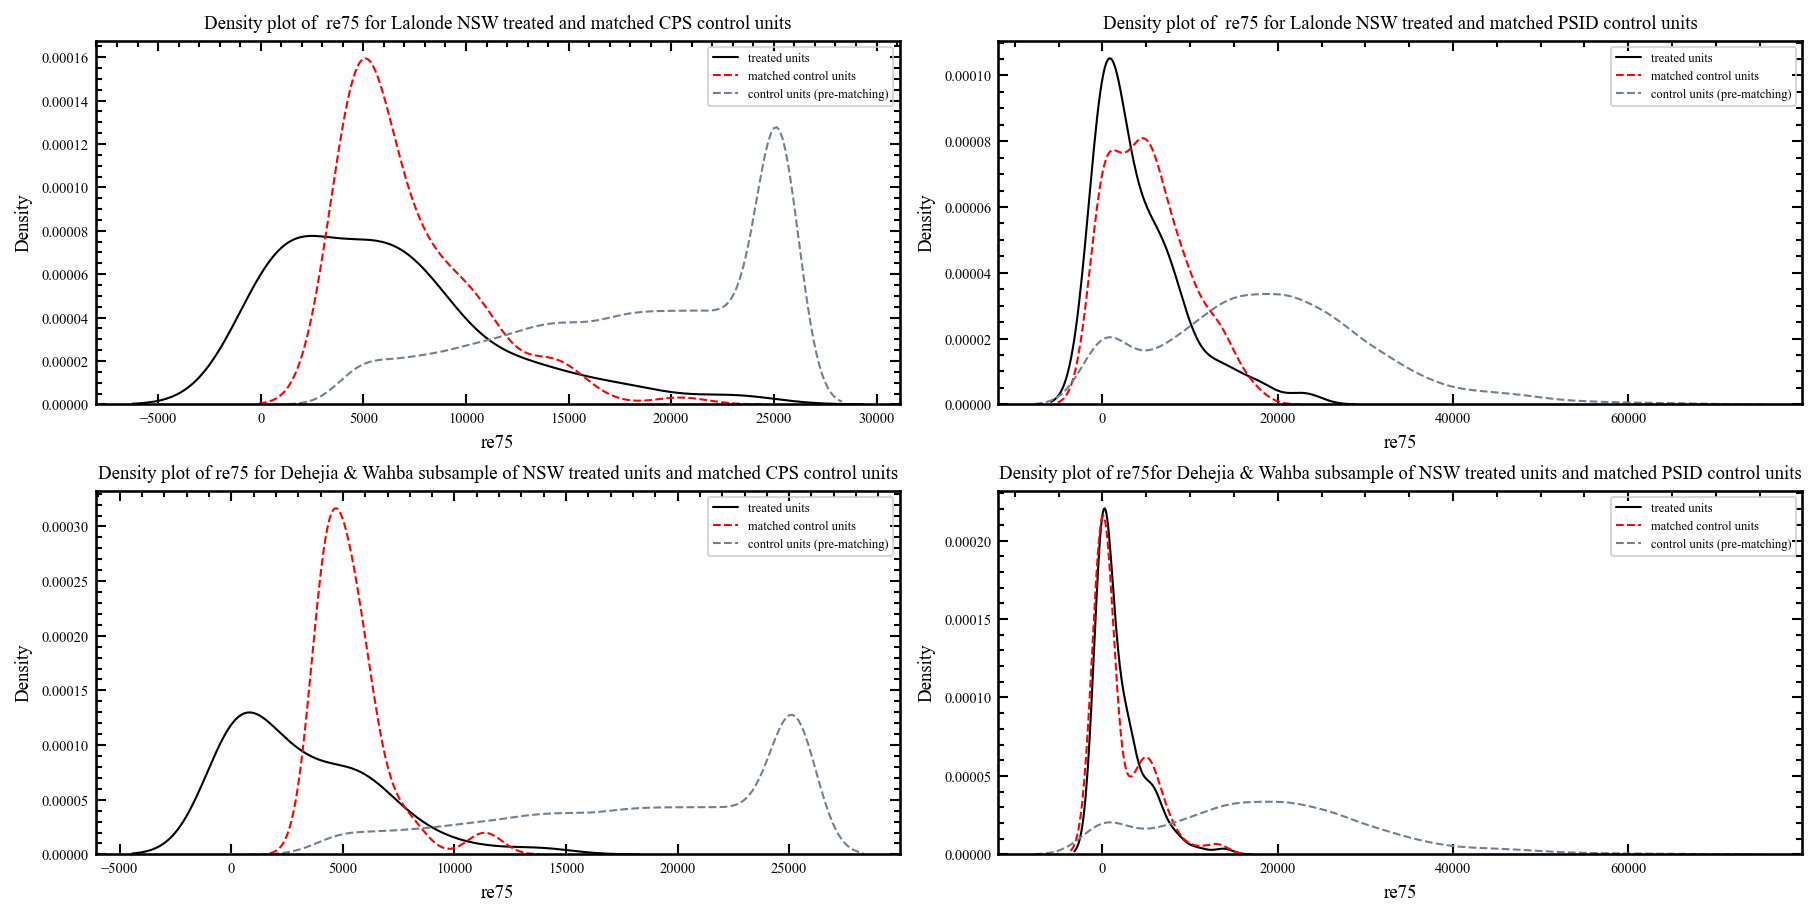

In [623]:
plot_matching_distributions(
                            're75',nswCps_lalonde_LOGIT_psMatched,nswCps_lalonde_ps_LOGIT_withRe78,
                            nswPsid_lalonde_LOGIT_psMatched,nswPsid_lalonde_ps_LOGIT_withRe78,
                            nswCps_dehWab_LOGIT_psMatched,nswCps_dehWab_ps_LOGIT_withRe78,
                            nswPsid_dehWab_LOGIT_psMatched,nswPsid_dehWab_ps_LOGIT_withRe78,
                            )

### covariate balance Plots

In [577]:
# Standardised difference in means 
def cohen_d(treated,control,save_results):
    for i in treated.columns:
        # Sample size 
        n1, n2 = len(treated[i]), len(control[i])
        # sample variance 
        s1, s2 = np.var(treated[i], ddof=1), np.var(control[i], ddof=1)
        #pooled standard deviation
        s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
        # sample means
        u1, u2 = np.mean(treated[i]), np.mean(control[i])
        # return cohends d
        coden_d = (u1 - u2) / s 
        save_results.loc[i,'cohens d'] = coden_d
    save_results = save_results.drop('treat')

    return  save_results

In [578]:
# Function to create a dataframe with adjusted 
def mean_difference_df(adjusted,unadjusted):

    # function to calculate cohens d
    def cohen_d(treated,control,save_results):
        for i in treated.columns:
            # Sample size 
            n1, n2 = len(treated[i]), len(control[i])
            # sample variance 
            s1, s2 = np.var(treated[i], ddof=1), np.var(control[i], ddof=1)
            #pooled standard deviation
            s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
            # sample means
            u1, u2 = np.mean(treated[i]), np.mean(control[i])
            # return cohends d
            coden_d = (u1 - u2) / s 
            save_results.loc[i,'cohens d'] = coden_d
        save_results = save_results.drop('treat')
        return  save_results
    
    adjusted_empty_df = pd.DataFrame()
    unadjusted_empty_df = pd.DataFrame()
    
    cohend_adjusted = cohen_d(adjusted[adjusted['treat']==1],adjusted[adjusted['treat']==0],adjusted_empty_df)
    cohend_adjusted = cohend_adjusted.rename(columns={'cohens d': 'matched'})
    
    cohend_unadjusted = cohen_d(unadjusted[unadjusted['treat']==1],unadjusted[unadjusted['treat']==0],unadjusted_empty_df)
    cohend_unadjusted = cohend_unadjusted.rename(columns={'cohens d': 'unmatched'})

    cohen_d_adj_unadj = pd.concat([cohend_adjusted,cohend_unadjusted],axis=1)

    if 're74' in cohen_d_adj_unadj.axes[0].tolist(): 
        cohen_d_adj_unadj = cohen_d_adj_unadj.loc[['propensity_score','age','education*','black','hispanic','re74','re75','re78']]
    else:
        cohen_d_adj_unadj = cohen_d_adj_unadj.loc[['propensity_score','age','education*','black','hispanic','re75','re78']]

    return cohen_d_adj_unadj

In [579]:
df_list_adjusted = [nswCps_lalonde_LOGIT_psMatched,nswPsid_lalonde_LOGIT_psMatched,
                    nswCps_dehWab_LOGIT_psMatched,nswPsid_dehWab_LOGIT_psMatched]

df_list_unadjusted = [nswCps_lalonde_ps_LOGIT_withRe78,nswPsid_lalonde_ps_LOGIT_withRe78,
                      nswCps_dehWab_ps_LOGIT_withRe78,nswPsid_dehWab_ps_LOGIT_withRe78]                

In [580]:
mean_differnces = []
for i, j in zip(df_list_adjusted, df_list_unadjusted):
  mean_differnces.append(mean_difference_df(i,j)) 

In [581]:
mean_differnces[0] # lalonde cps

,matched,unmatched
propensity_score,0.006087,5.055605
age,0.123602,-1.014874
education*,-0.125428,-0.774608
black,-0.214141,3.005317
hispanic,0.160074,0.171878
re75,-0.282845,-2.442874
re78,-1.419943,-2.711111


In [582]:
mean_differnces[1] # lalonde psid

,matched,unmatched
propensity_score,0.006997,3.305572
age,0.251632,-0.983007
education*,-0.030209,-0.754797
black,-0.034401,1.330159
hispanic,0.320026,0.378006
re75,-0.214296,-1.379258
re78,-0.285636,-1.193839


In [583]:
mean_differnces[2] # dehejia wabha cps

,matched,unmatched
propensity_score,0.006044,5.722599
age,-0.492036,-0.906408
education*,1.104195,-0.769378
black,2.011581,3.202863
hispanic,-0.062622,0.037236
re74,-0.197679,-2.285460
re75,-0.847453,-2.684947
re78,-1.235642,-2.678086


In [584]:
mean_differnces[3] # dehejia waba cps

,matched,unmatched
propensity_score,0.014341,3.207416
age,-0.331353,-0.863832
education*,0.222176,-0.741037
black,0.911056,1.424539
hispanic,0.158912,0.220043
re74,-0.178110,-1.506133
re75,-0.018071,-1.491043
re78,0.098965,-1.159209


In [613]:
from matplotlib.lines import Line2D
def plot_mean_difference(cohen_d_dataframe,cohen_d_dataframe2,save_name):

    fig, ax = plt.subplots(figsize=(5, 3))

    # Neat formatting for plots 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022())
    plt.rcParams.update(fontsizes.neurips2022())

    ax.set_facecolor('white')
    # Set boarder colour 
    for spine in ax.spines:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1)

    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.6, alpha=0.3)
    ax.grid(color='white', axis='x')

    

    if 're74' in cohen_d_dataframe.axes[0].tolist(): 
        yticklabels =['','propensity score','age','education','black','hispanic','re74','re75','re78']
        ax.set_yticklabels(yticklabels)
    else:
        yticklabels = ['','propensity score','age','education','black','hispanic','re75','re78']
        ax.set_yticklabels(yticklabels)

    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.xaxis.set_tick_params(which='major', bottom=False)
    ax.tick_params(right='on',which='major',length= 5, width = 1)
    ax.tick_params(left='on',which='major',length= 5, width = 1)
    ax.tick_params(bottom ='on',which='major',length=3, width = 1)

    ax.axvline(x=0.2, color='red', linestyle='-',linewidth=0.7)
    ax.axvline(x=-0.2, color='red', linestyle='-',linewidth=0.7)
    #ax.axvline(x= 0, color='black', linestyle='-',linewidth=0.7)
    if 're74' in cohen_d_dataframe.axes[0].tolist():
        ax.plot(cohen_d_dataframe['matched'],range(-2,6) ,'o',color='dodgerblue',fillstyle='full')
        ax.plot(cohen_d_dataframe['unmatched'],range(-2,6) ,'+',color='crimson',fillstyle='full')
        ax.set_xlim(-3.5,3.6)
        ax.plot(cohen_d_dataframe2['matched'],range(-2,6) ,'o',color='steelblue',fillstyle='full')
        ax.plot(cohen_d_dataframe2['unmatched'],range(-2,6) ,'+',color='darkred',fillstyle='full')
    else:
        ax.plot(cohen_d_dataframe['matched'],range(-2,5) ,'o',color='dodgerblue',fillstyle='full')
        ax.plot(cohen_d_dataframe['unmatched'],range(-2,5) ,'+',color='crimson',fillstyle='full')
        ax.set_xlim(-3.5,3.6)
        ax.plot(cohen_d_dataframe2['matched'],range(-2,5) ,'o',color='steelblue',fillstyle='full')
        ax.plot(cohen_d_dataframe2['unmatched'],range(-2,5) ,'+',color='darkred',fillstyle='full')

    ax.set_xlabel('standardised mean difference')
    legend_elements = [Line2D([0],[0], lw=0,marker='o', color='dodgerblue', label='cps adjusted ',markersize=5),
                       Line2D([0],[0],lw=0, marker='+', color='crimson', label='cps unadjusted', markersize=5),
                       Line2D([0],[0],lw=0, marker='o', color='steelblue',label='psid adjusted ', markersize=5),
                       Line2D([0],[0],lw=0, marker='+', color='darkred',label='psid unadjusted', markersize=5)]

    ax.legend(handles=legend_elements)
    #ax.set_ylabel('covariate')
    plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/'f'{save_name}''.png', bbox_inches='tight')

    plt.show()


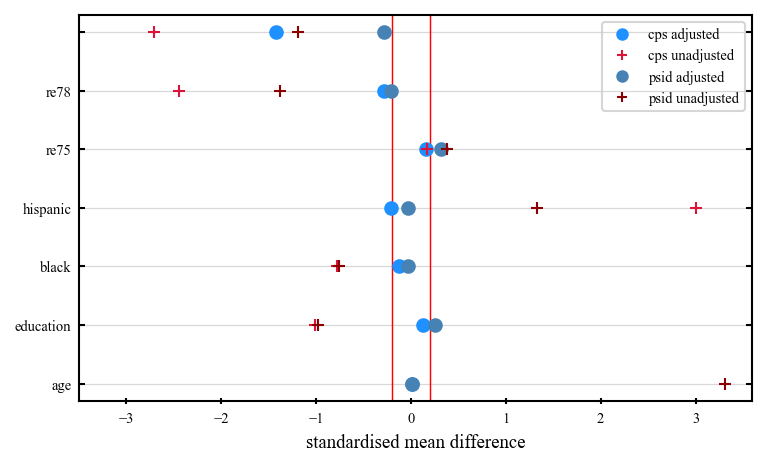

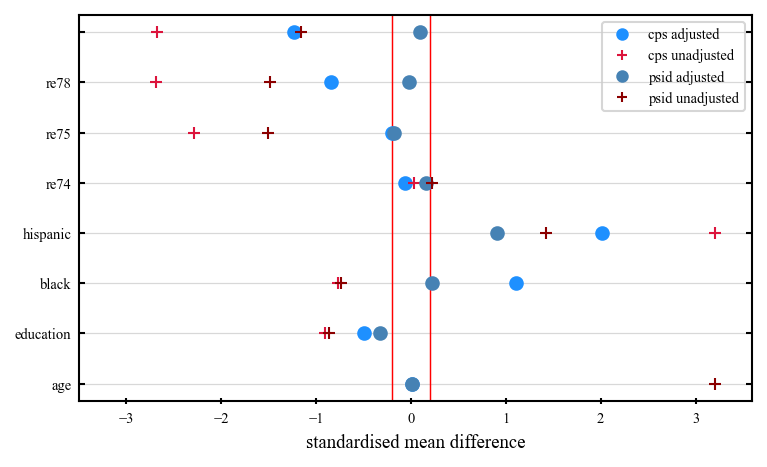

In [589]:
# Plot standardised mean difference
# Lalonde CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[0],mean_differnces[1],"logit/lalonde_smd")
# Dehwab CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[2],mean_differnces[3],"logit/dehwab_smd")

<p> Estimate ATE </p>

### model (2) ; CART 

In [590]:
# Import libraries 
from sklearn import tree          
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz               

#### Data prep for CART

In [622]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78



,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,0,9930,11,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,0,3595,9,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,0,24909,12,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,0,7506,11,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,0,289,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10038,0.0,27,0.0,0.0,1.0,0.0,25507,25243,25564,13,...,0,0,0,0,1,0,0,0,0,0
10039,0.0,55,0.0,0.0,1.0,1.0,25862,25243,21463,9,...,1,0,0,0,0,0,0,0,0,0
10040,0.0,48,0.0,0.0,1.0,1.0,25862,25243,25564,10,...,0,1,0,0,0,0,0,0,0,0
10041,0.0,47,0.0,0.0,1.0,1.0,16914,11384,13671,9,...,1,0,0,0,0,0,0,0,0,0


In [621]:
""" Select covariates for use in CART model """
sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]
#lalonde_continuous_vars = ['age','education*','lnre75']  # continuous  variables to be scaled 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswCps_lalonde_subset[lalonde_continuous_vars])
#nswPsid_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswPsid_lalonde_subset[lalonde_continuous_vars])

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]
# continuous  variables to be scaled 
#nswDW_continuous_vars = ['age','education*','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswCps_dehWab_subset[nswDW_continuous_vars])
#nswPsid_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswDW_continuous_vars])
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


,age,education*,black,hispanic,married,nodegree,re74,re75
0,37,11,1.0,0.0,1.0,1.0,0,0
1,22,9,0.0,1.0,0.0,1.0,0,0
2,30,12,1.0,0.0,0.0,0.0,0,0
3,27,11,1.0,0.0,0.0,1.0,0,0
4,33,8,1.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...
10038,27,13,0.0,0.0,1.0,0.0,25507,25243
10039,55,9,0.0,0.0,1.0,1.0,25862,25243
10040,48,10,0.0,0.0,1.0,1.0,25862,25243
10041,47,9,0.0,0.0,1.0,1.0,16914,11384


## Validation 

In [593]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [594]:
# dataframes to store resutls 
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()
#models 
grid_search_cart1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart3 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart4 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)


In [595]:
# Takes appx 65 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 

In [597]:
cart1_metrics.loc['RMSE']=np.sqrt(cart1_metrics.loc["MSE:"])
cart2_metrics.loc['RMSE']=np.sqrt(cart2_metrics.loc["MSE:"])
cart3_metrics.loc['RMSE']=np.sqrt(cart3_metrics.loc["MSE:"])
cart4_metrics.loc['RMSE']=np.sqrt(cart4_metrics.loc["MSE:"])

cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [598]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.866071,0.830357,0.881818,0.881059,0.872727,0.866407
Precision:,1.000000,1.000000,1.000000,0.933333,1.000000,0.986667
Recall:,0.732143,0.660714,0.763636,0.763636,0.745455,0.733117
MSE:,0.007386,0.009355,0.006401,0.007882,0.006897,0.007584
MAE:,0.007386,0.009355,0.006401,0.007882,0.006897,0.007584
F1:,0.845361,0.795699,0.865979,0.840000,0.854167,0.840241
Kappa:,0.841670,0.791116,0.862761,0.836001,0.850712,0.836452
RMSE,0.085939,0.096721,0.080005,0.088779,0.083045,0.086898


In [599]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.881004,0.819847,0.886462,0.761951,0.866732,0.843199
Precision:,0.800000,0.678571,0.681818,0.750000,0.750000,0.732078
Recall:,0.785714,0.678571,0.818182,0.545455,0.763636,0.718312
MSE:,0.044231,0.069364,0.059730,0.067437,0.052023,0.058557
MAE:,0.044231,0.069364,0.059730,0.067437,0.052023,0.058557
F1:,0.792793,0.678571,0.743802,0.631579,0.756757,0.720700
Kappa:,0.768037,0.639695,0.710312,0.595479,0.727633,0.688231
RMSE,0.210311,0.263371,0.244398,0.259687,0.228086,0.241170


In [600]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.970588,0.970588,0.909091,0.954545,0.893939,0.939750
Precision:,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Recall:,0.941176,0.941176,0.818182,0.909091,0.787879,0.879501
MSE:,0.000996,0.000996,0.002987,0.001494,0.003486,0.001992
MAE:,0.000996,0.000996,0.002987,0.001494,0.003486,0.001992
F1:,0.969697,0.969697,0.900000,0.952381,0.881356,0.934626
Kappa:,0.969191,0.969191,0.898499,0.951624,0.879612,0.933624
RMSE,0.031552,0.031552,0.054649,0.038653,0.059043,0.043090


In [601]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.802358,0.864407,0.818182,0.829023,0.693737,0.801541
Precision:,0.777778,0.892857,1.000000,0.846154,0.812500,0.865858
Recall:,0.617647,0.735294,0.636364,0.666667,0.393939,0.609982
MSE:,0.038153,0.024145,0.024145,0.030181,0.046278,0.032580
MAE:,0.038153,0.024145,0.024145,0.030181,0.046278,0.032580
F1:,0.688525,0.806452,0.777778,0.745763,0.530612,0.709826
Kappa:,0.668489,0.793705,0.765677,0.729960,0.509336,0.693433
RMSE,0.195327,0.155386,0.155386,0.173727,0.215122,0.178990


### Inference

In [602]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_CART = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1)
nswPsid_lalonde_ps_CART = propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_CART_withRe78 = pd.merge(nswCps_lalonde_ps_CART,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_CART_withRe78 = pd.merge(nswPsid_lalonde_ps_CART,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3)
nswPsid_dehWab_ps_CART = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_CART_withRe78 = pd.merge(nswCps_dehWab_ps_CART,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_CART_withRe78  = pd.merge(nswPsid_dehWab_ps_CART,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [603]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde sample ============ # 
# CPS
caliper = np.std(nswCps_lalonde_ps_CART_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_lalonde_CART_psMatched  = psm.match(nswCps_lalonde_ps_CART_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_lalonde_ps_CART_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_lalonde_CART_psMatched = psm.match(nswPsid_lalonde_ps_CART_withRe78,'treat',['propensity_score'])

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
caliper = np.std(nswCps_dehWab_ps_CART_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_dehWab_CART_psMatched  = psm.match(nswCps_dehWab_ps_CART_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_dehWab_ps_CART_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_dehWab_CART_psMatched = psm.match(nswPsid_dehWab_ps_CART_withRe78,'treat',['propensity_score'])


print('laonde cps : ',nswCps_lalonde_CART_psMatched.shape)
print('laonde psid : ',nswPsid_lalonde_CART_psMatched.shape)
print('dehwab cps : ',nswCps_dehWab_CART_psMatched.shape)
print('dehwab psid : ',nswPsid_dehWab_CART_psMatched.shape)

laonde cps :  (146, 11)
laonde psid :  (270, 11)
dehwab cps :  (38, 12)
dehwab psid :  (176, 12)


In [604]:
# SAVE Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_lalonde_CART_psMatched.csv',header = True,index = False)
nswPsid_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_lalonde_CART_psMatched.csv',header = True,index = False)
nswCps_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_dehWab_CART_psMatched.csv',header = True,index = False)
nswPsid_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_dehWab_CART_psMatched.csv',header = True,index = False)

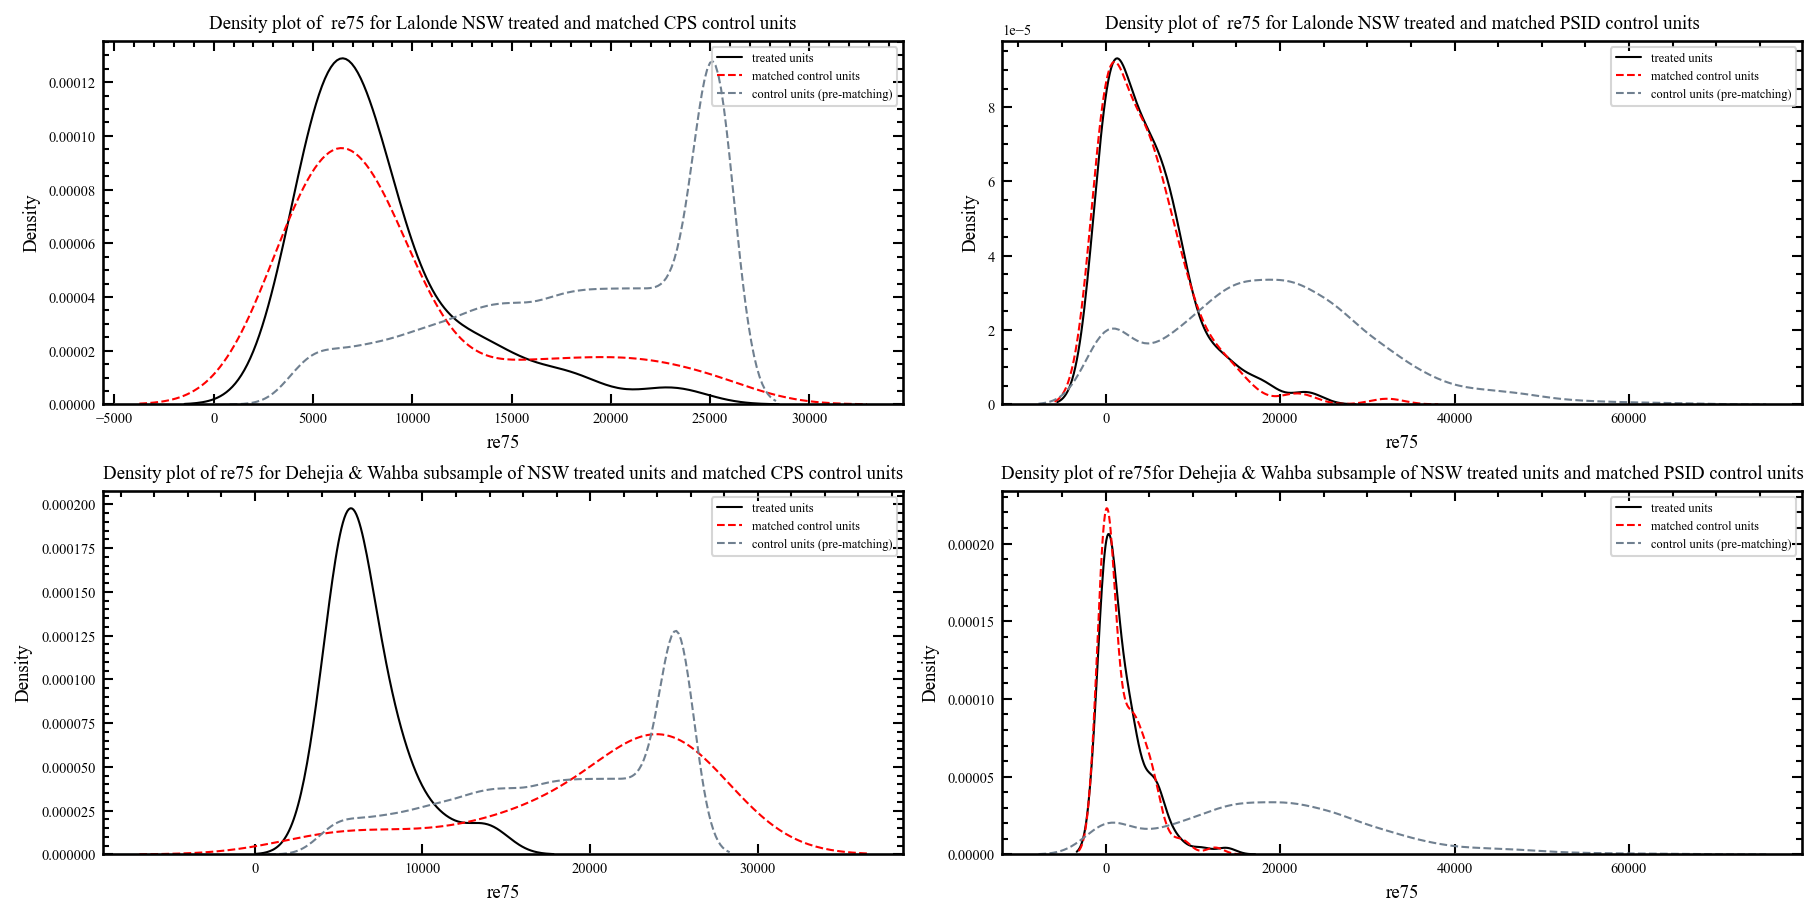

In [620]:
plot_matching_distributions(
                            're75',nswCps_lalonde_CART_psMatched,nswCps_lalonde_ps_CART_withRe78,
                            nswPsid_lalonde_CART_psMatched,nswPsid_lalonde_ps_CART_withRe78,
                            nswCps_dehWab_CART_psMatched,nswCps_dehWab_ps_CART_withRe78,
                            nswPsid_dehWab_CART_psMatched,nswPsid_dehWab_ps_CART_withRe78,
                            )

In [606]:
df_list_adjusted = [nswCps_lalonde_CART_psMatched,nswPsid_lalonde_CART_psMatched,
                    nswCps_dehWab_CART_psMatched,nswPsid_dehWab_CART_psMatched]

df_list_unadjusted = [nswCps_lalonde_ps_CART_withRe78,nswPsid_lalonde_ps_CART_withRe78,
                      nswCps_dehWab_ps_CART_withRe78,nswPsid_dehWab_ps_CART_withRe78]                

In [607]:
mean_differnces = []
for i, j in zip(df_list_adjusted, df_list_unadjusted):
  mean_differnces.append(mean_difference_df(i,j)) 

In [608]:
mean_differnces[0] # lalonde cps

,matched,unmatched
propensity_score,0.000000,11.234881
age,-0.539364,-1.014874
education*,-0.605880,-0.774608
black,0.000000,3.005317
hispanic,0.622939,0.171878
re75,-0.202421,-2.442874
re78,-1.592389,-2.711111


In [609]:
mean_differnces[1] # lalonde psid

,matched,unmatched
propensity_score,0.000000,4.008847
age,-0.442640,-0.983007
education*,-0.521419,-0.754797
black,0.126211,1.330159
hispanic,0.369234,0.378006
re75,0.043072,-1.379258
re78,-0.290343,-1.193839


In [610]:
mean_differnces[2] # dehejia wabha cps

,matched,unmatched
propensity_score,0.000000,21.641348
age,-1.112642,-0.906408
education*,-0.619240,-0.769378
black,2.026145,3.202863
hispanic,0.710819,0.037236
re74,-1.865240,-2.285460
re75,-2.636643,-2.684947
re78,-2.212464,-2.678086


In [611]:
mean_differnces[3] # dehejia waba cps

,matched,unmatched
propensity_score,0.000000,4.612569
age,-0.622890,-0.863832
education*,-0.926827,-0.741037
black,0.073179,1.424539
hispanic,0.331246,0.220043
re74,-0.041351,-1.506133
re75,0.063396,-1.491043
re78,-0.049131,-1.159209


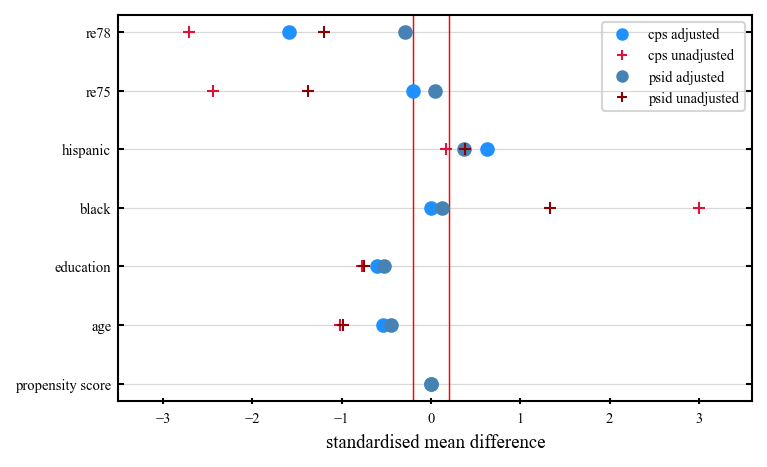

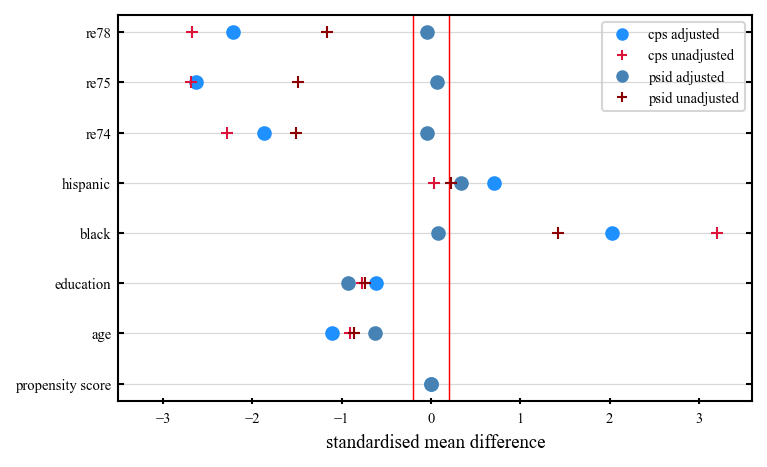

In [614]:
# Plot standardised mean difference
# Lalonde CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[0],mean_differnces[1],"cart/lalonde_smd")
# Dehwab CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[2],mean_differnces[3],"cart/dehwab_smd")

### model (3) ; Random Forest

In [627]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [628]:
nswCps_lalonde

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10148,0.0,27,0.0,0.0,1.0,0.0,25243,25564,13,0,...,0,0,0,0,1,0,0,0,0,0
10149,0.0,55,0.0,0.0,1.0,1.0,25243,21463,9,0,...,1,0,0,0,0,0,0,0,0,0
10150,0.0,48,0.0,0.0,1.0,1.0,25243,25564,10,0,...,0,1,0,0,0,0,0,0,0,0
10151,0.0,47,0.0,0.0,1.0,1.0,11384,13671,9,0,...,1,0,0,0,0,0,0,0,0,0


In [629]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]
#lalonde_continuous_vars = ['age','education*','lnre75']  # continuous  variables to be scaled 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswCps_lalonde_subset[lalonde_continuous_vars])
#nswPsid_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswPsid_lalonde_subset[lalonde_continuous_vars])

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]
# continuous  variables to be scaled 
#nswDW_continuous_vars = ['age','education*','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswCps_dehWab_subset[nswDW_continuous_vars])
#nswPsid_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswDW_continuous_vars])

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)





## Validation 

In [630]:
from sklearn import tree          
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [631]:
# Grid search 
forest_param_grid = { 
    'n_estimators': [100,500,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split':[1,2,3],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [632]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
# dataframes to store resutls 
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()
#models 
grid_search_forest1 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest2 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest3 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest4 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)

In [54]:
kfold_evaluation(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits


,0,1,2,3,4
Accuracy:,0.50000,0.50000,0.50000,0.50000,0.560137
Precision:,0.00000,0.00000,0.00000,0.00000,0.571429
Recall:,0.00000,0.00000,0.00000,0.00000,0.121212
MSE:,0.01052,0.01052,0.01021,0.01021,0.009904
MAE:,0.01052,0.01052,0.01021,0.01021,0.009904
F1:,0.00000,0.00000,0.00000,0.00000,0.200000
Kappa:,0.00000,0.00000,0.00000,0.00000,0.197130


In [633]:
# Takes appx 110 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

In [634]:
forest1_metrics

,0,1,2,3,4
Accuracy:,0.875000,0.847708,0.917676,0.881565,0.890909
Precision:,1.000000,0.951220,0.958333,0.976744,1.000000
Recall:,0.750000,0.696429,0.836364,0.763636,0.781818
MSE:,0.006893,0.009355,0.005416,0.006897,0.005911
MAE:,0.006893,0.009355,0.005416,0.006897,0.005911
R^2:,0.742911,0.651094,0.794433,0.738366,0.775742
F1:,0.857143,0.804124,0.893204,0.857143,0.877551
Kappa:,0.853685,0.799449,0.890439,0.853664,0.874569


In [635]:
forest2_metrics

,0,1,2,3,4
Accuracy:,0.823892,0.765987,0.841614,0.811716,0.818652
Precision:,0.860465,0.756098,0.764706,0.853659,0.818182
Recall:,0.660714,0.553571,0.709091,0.636364,0.654545
MSE:,0.048077,0.067437,0.053950,0.050096,0.052023
MAE:,0.048077,0.067437,0.053950,0.050096,0.052023
R^2:,0.499692,0.299406,0.430564,0.471238,0.450901
F1:,0.747475,0.639175,0.735849,0.729167,0.727273
Kappa:,0.721413,0.602959,0.705854,0.702211,0.698911


In [636]:
forest3_metrics

,0,1,2,3,4
Accuracy:,0.970588,0.970588,0.909091,0.954545,0.893939
Precision:,1.000000,1.000000,1.000000,1.000000,1.000000
Recall:,0.941176,0.941176,0.818182,0.909091,0.787879
MSE:,0.000996,0.000996,0.002987,0.001494,0.003486
MAE:,0.000996,0.000996,0.002987,0.001494,0.003486
R^2:,0.940164,0.940164,0.815145,0.907572,0.784334
F1:,0.969697,0.969697,0.900000,0.952381,0.881356
Kappa:,0.969191,0.969191,0.898499,0.951624,0.879612


In [637]:
forest4_metrics

,0,1,2,3,4
Accuracy:,0.895981,0.832836,0.818182,0.767339,0.824713
Precision:,0.964286,0.821429,1.000000,0.782609,0.733333
Recall:,0.794118,0.676471,0.636364,0.545455,0.666667
MSE:,0.016064,0.032193,0.024145,0.040241,0.038229
MAE:,0.016064,0.032193,0.024145,0.040241,0.038229
R^2:,0.747465,0.494855,0.610502,0.350836,0.383294
F1:,0.870968,0.741935,0.777778,0.642857,0.698413
Kappa:,0.862488,0.724939,0.765677,0.622254,0.678054


### Inference

In [638]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_FOREST = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1)
nswPsid_lalonde_ps_FOREST = propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_FOREST_withRe78 = pd.merge(nswCps_lalonde_ps_FOREST,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_FOREST_withRe78 = pd.merge(nswPsid_lalonde_ps_FOREST,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_FOREST = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3)
nswPsid_dehWab_ps_FOREST = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_FOREST_withRe78 = pd.merge(nswCps_dehWab_ps_FOREST,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_FOREST_withRe78  = pd.merge(nswPsid_dehWab_ps_FOREST,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [639]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST.csv')

In [640]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde sample ============ # 
# CPS
caliper = np.std(nswCps_lalonde_ps_FOREST_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_lalonde_FOREST_psMatched  = psm.match(nswCps_lalonde_ps_FOREST_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_lalonde_ps_FOREST_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_lalonde_FOREST_psMatched = psm.match(nswPsid_lalonde_ps_FOREST_withRe78,'treat',['propensity_score'])

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
caliper = np.std(nswCps_dehWab_ps_FOREST_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_dehWab_FOREST_psMatched  = psm.match(nswCps_dehWab_ps_FOREST_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_dehWab_ps_FOREST_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_dehWab_FOREST_psMatched = psm.match(nswPsid_dehWab_ps_FOREST_withRe78,'treat',['propensity_score'])


print('laonde cps : ',nswCps_lalonde_FOREST_psMatched.shape)
print('laonde psid : ',nswPsid_lalonde_FOREST_psMatched.shape)
print('dehwab cps : ',nswCps_dehWab_FOREST_psMatched.shape)
print('dehwab psid : ',nswPsid_dehWab_FOREST_psMatched.shape)

laonde cps :  (54, 11)
laonde psid :  (224, 11)
dehwab cps :  (18, 12)
dehwab psid :  (64, 12)


In [641]:
# SAVE Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_lalonde_forest_psMatched.csv',header = True,index = False)
nswPsid_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_lalonde_forest_psMatched.csv',header = True,index = False)
nswCps_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_dehWab_forest_psMatched.csv',header = True,index = False)
nswPsid_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_dehWab_forest_psMatched.csv',header = True,index = False)

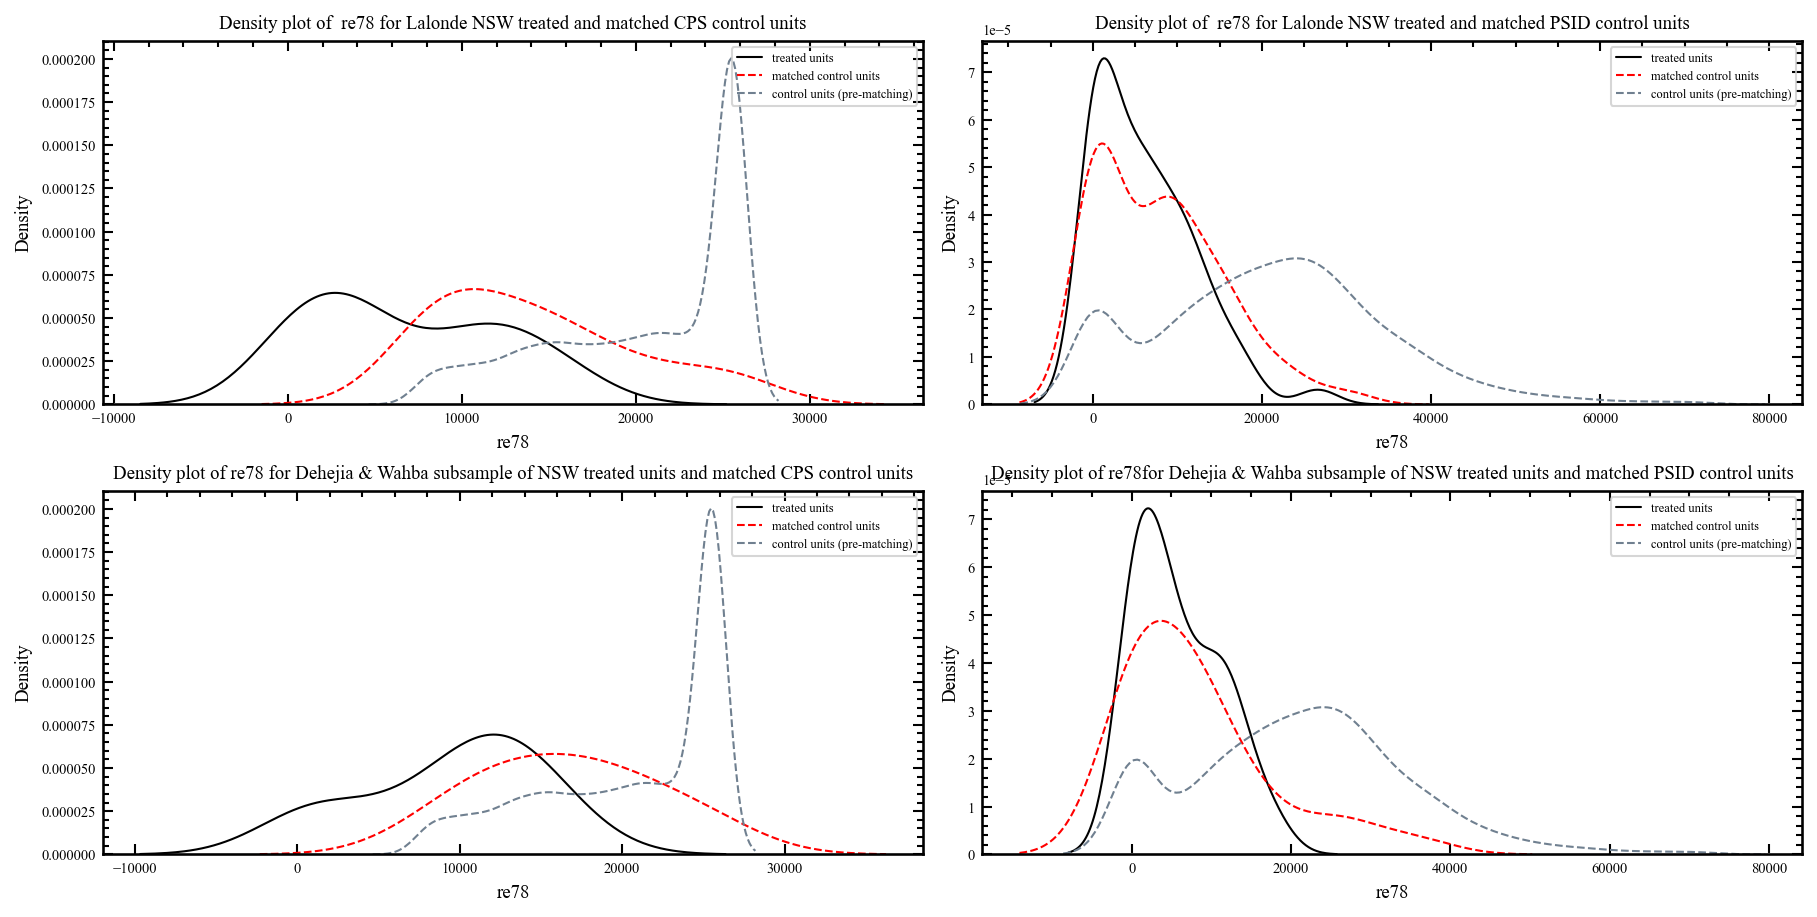

In [643]:
plot_matching_distributions(
                            're78',nswCps_lalonde_FOREST_psMatched,nswCps_lalonde_ps_FOREST_withRe78,
                            nswPsid_lalonde_FOREST_psMatched,nswPsid_lalonde_ps_FOREST_withRe78,
                            nswCps_dehWab_FOREST_psMatched,nswCps_dehWab_ps_FOREST_withRe78,
                            nswPsid_dehWab_FOREST_psMatched,nswPsid_dehWab_ps_FOREST_withRe78,
                            )

In [644]:
df_list_adjusted = [nswCps_lalonde_FOREST_psMatched,nswPsid_lalonde_FOREST_psMatched,
                    nswCps_dehWab_FOREST_psMatched,nswPsid_dehWab_FOREST_psMatched]

df_list_unadjusted = [nswCps_lalonde_ps_FOREST_withRe78,nswPsid_lalonde_ps_FOREST_withRe78,
                      nswCps_dehWab_ps_FOREST_withRe78,nswPsid_dehWab_ps_FOREST_withRe78]                

In [645]:
mean_differnces = []
for i, j in zip(df_list_adjusted, df_list_unadjusted):
  mean_differnces.append(mean_difference_df(i,j)) 

In [646]:
mean_differnces[0] # lalonde cps

,matched,unmatched
propensity_score,0.000644,16.729818
age,0.284122,-1.014874
education*,0.236546,-0.774608
black,-0.476004,3.005317
hispanic,0.000000,0.171878
re75,0.060830,-2.442874
re78,-1.324102,-2.711111


In [647]:
mean_differnces[0]

,matched,unmatched
propensity_score,-0.002268,4.287408
age,0.058830,-0.983007
education*,0.005099,-0.754797
black,0.000000,1.330159
hispanic,0.187857,0.378006
re75,-0.030804,-1.379258
re78,-0.266369,-1.193839


In [648]:
mean_differnces[1]

,matched,unmatched
propensity_score,-0.000958,24.703055
age,-0.081203,-0.906408
education*,-0.045466,-0.769378
black,0.432590,3.202863
hispanic,-0.284268,0.037236
re74,-0.002850,-2.285460
re75,-0.944968,-2.684947
re78,-1.322630,-2.678086


In [649]:
mean_differnces[2]

,matched,unmatched
propensity_score,0.003843,7.470603
age,0.217112,-0.863832
education*,-0.263641,-0.741037
black,0.067361,1.424539
hispanic,0.000000,0.220043
re74,0.077230,-1.506133
re75,0.305787,-1.491043
re78,-0.311435,-1.159209


In [650]:
mean_differnces[3]

,matched,unmatched
propensity_score,0.003843,7.470603
age,0.217112,-0.863832
education*,-0.263641,-0.741037
black,0.067361,1.424539
hispanic,0.000000,0.220043
re74,0.077230,-1.506133
re75,0.305787,-1.491043
re78,-0.311435,-1.159209


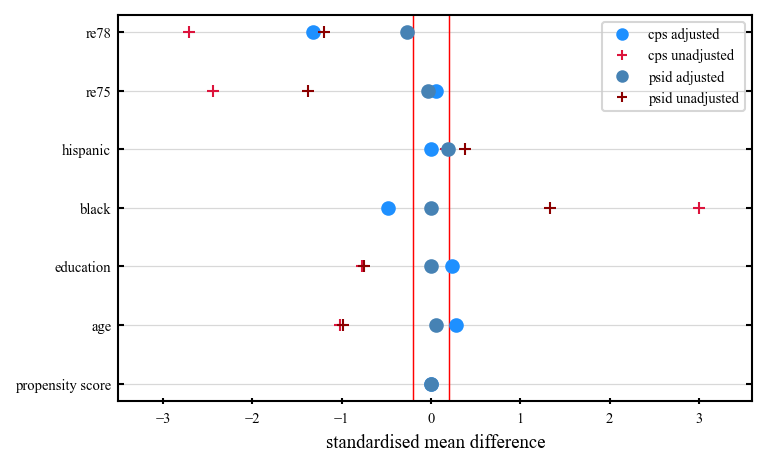

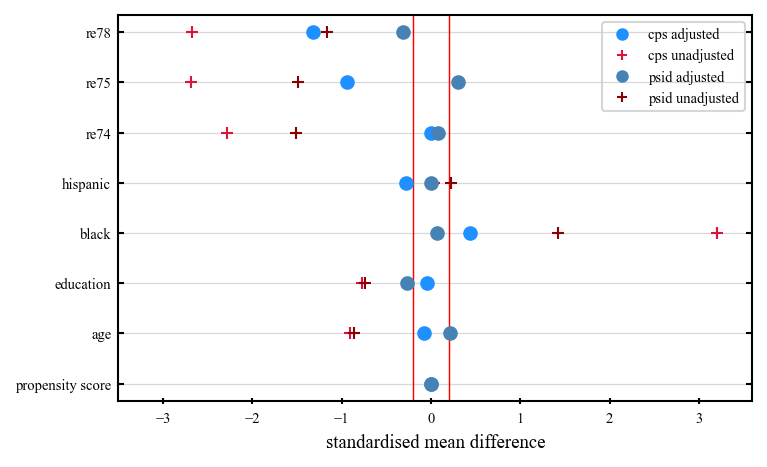

In [652]:
# Plot standardised mean difference
# Lalonde CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[0],mean_differnces[1],"forest/lalonde_smd")
# Dehwab CPS and PSID standardised mean differences 
plot_mean_difference(mean_differnces[2],mean_differnces[3],"forest/dehwab_smd")

### model (4) ; Boosted Trees

In [ ]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [74]:
from xgboost import XGBClassifier
from xgboost import plot_tree

In [95]:
# Boosting parameters 
""""
Booster = type of model to run at each iteration
subsample = fraction of training samples (randomly selected) used to train each tree
colsample_bytree = fraction of features (randomly selected) used to train each tree

min_child_weight [default = 1] : Used to control over-fitting. 
                                Higher values prevent a model from learning 
                                relations which might be highly specific to the 
                                particular sample selected for a tree.

max_depth = max tree depth 
"""

params = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,3,4,5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
        'learning_rate': [0.01,0.025,0.05,0.075,0.1,0.2,0.3]
        }

params2 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.5, 0.7,0.8],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,None],
        'learning_rate': [0.01,0.025,0.05]
        }        

# Set up tree classifier
estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42,
    nthread=4
)       

# Set up grid search 
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'roc_auc',
    cv = 5,
    verbose= True
)

In [96]:
# Fit models
# ======== Lalonde (1986) sample ======== #
model1 = grid_search.fit(FEATURES_train,TARGET_train)
y_pred= model1.predict(FEATURES_test)
# ======== Dehejia & Wahba (1999) sub sample ======== #
model2 =grid_search.fit(FEATURES_DW_train,TARGET_DW_train)
y_pred_dw = model2.predict(FEATURES_DW_test)

Fitting 5 folds for each of 61600 candidates, totalling 308000 fits


KeyboardInterrupt: 

In [97]:
#y_pred= model1.predict(FEATURES_test)
y_pred = grid_search.predict(FEATURES_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [71]:
""" XGboost metrics """

# ======== Lalonde (1986) sample ======== #

print('--------------------- XGBoost metrics ---------------------')
print('lalonde sample')

print(f'Accuracy : {metrics.accuracy_score(TARGET_test, y_pred):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_test, y_pred):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_test, y_pred):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_test, y_pred):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_test, y_pred):.2f}')
print('____________________________________________________')

# ======== Dehejia & Wahba (1999) sub sample ======== #

#print('dehejia & wahba sample')
#print(f'Accuracy : {metrics.accuracy_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'Precision : {metrics.precision_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'Recall : {metrics.recall_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'MSE : {metrics.mean_squared_error(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'f1 score : {metrics.f1_score(TARGET_DW_test, tree_predictions2):.2f}')

print('____________________________________________________')

--------------------- XGBoost metrics ---------------------
lalonde sample
Accuracy : 0.57
Precision : 0.27
Recall : 0.05
MSE : 0.43
f1 score : 0.09
____________________________________________________
____________________________________________________


### model (5) - artifical neural network

#### define ANN class 

In [46]:
class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<p> test distributions</p>

<p> plot distribtions of key variables pre and post matching </p>

(-10000.0, 45000.0)

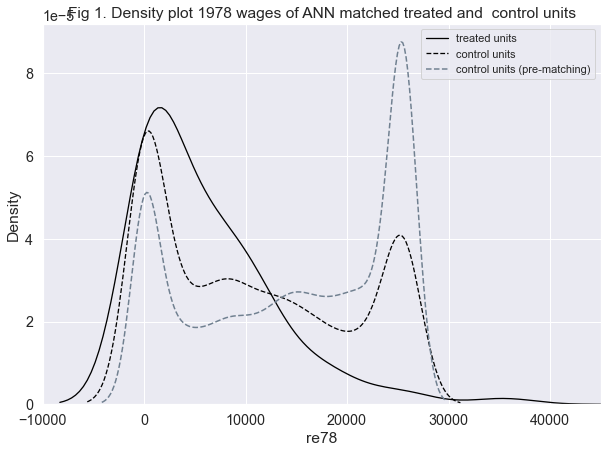

In [50]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['re78'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['re78'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
plt.title('Fig 1. Density plot 1978 wages of ANN matched treated and  control units')
# Density plots pre-matching
sns.kdeplot(before_matched_df['re78'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.legend(fontsize=11,loc = 1)
plt.xlim([-10000, 45000])



(2.0, 21.0)

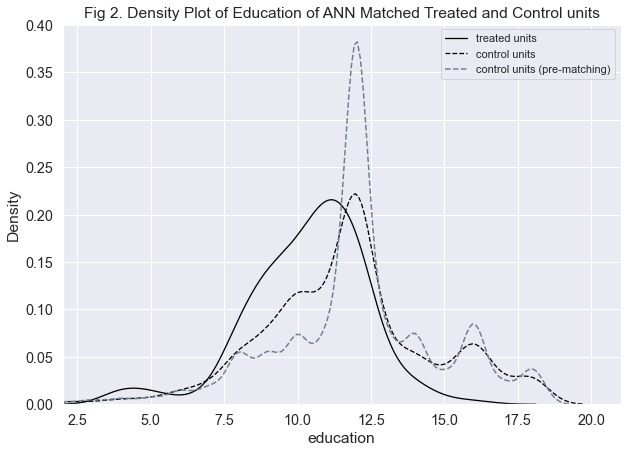

In [51]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['education'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['education'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
sns.kdeplot(before_matched_df['education'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')
plt.title('Fig 2. Density Plot of Education of ANN Matched Treated and Control units')
plt.legend(fontsize=11,loc = 1)
plt.xlim([2, 21])

# Matching Anlysis

In [118]:
# Load quasi datasets 

# Logit 

logitNswCps_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedCpsComparison.csv')
logitNswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedPsidComparison.csv')
logitNswCps_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedCpsComparison.csv')
logitNswPsid_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedPsidComparison.csv')

# Cart 

cartNswCps_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedcpsComparison.csv')
cartNswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedpsidComparison.csv')
cartNswCps_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedcpsComparison.csv')
cartNswPsid_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedpsidComparison.csv')


# Forest 

# XGBoosted tree  

# ANN tree model 

min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q5 0.3047619047619048


In [127]:
print('treated')
print('min',np.min(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('max',np.max(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('median',np.median(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('Q1',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1], 25)) 
print('Q3',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1], 75)) 
print('control')
print('min',np.min(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('max',np.max(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('median',np.median(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('Q1',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0], 25)) 
print('Q3',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0], 75)) 

treated
min 0.3458259121357014
max 0.601949267164903
median 0.4499112381214718
Q1 0.4184566696975808
Q3 0.48683804987340856
control
min 0.3462317153588036
max 0.601953759453305
median 0.44995011037502364
Q1 0.41855193399124035
Q3 0.48682041011957167


In [126]:
print('treated')
print('min',np.min(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('max',np.max(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('median',np.median(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('Q1',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1], 25)) 
print('Q3',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1], 75)) 
print('control')
print('min',np.min(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('max',np.max(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('median',np.median(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('Q1',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0], 25)) 
print('Q3',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0], 75)) 

treated
min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q3 0.6666666666666666
control
min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q3 0.6666666666666666


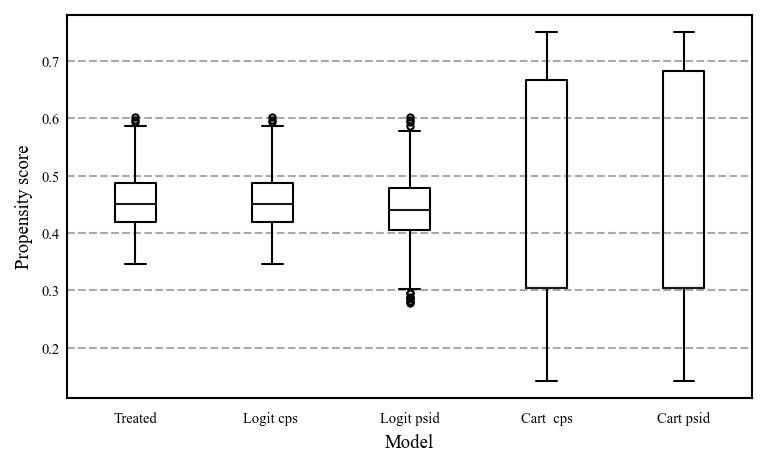

In [120]:
# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()